#Загрузка библиотек

In [ ]:
!pip install yfinance

In [ ]:
!pip install prophet

ERROR: Operation cancelled by user


In [ ]:
!pip install numpy==1.21.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 37.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.21.6 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 1.21.6 which is incompatible.
flax 0.8.4 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
jax 0.4.26 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
jaxlib 0.4.26+cuda12.cudnn89 requires numpy>=1.22, but you have numpy 1.21.6 which is incompatible.
numba 0.58.1 requires numpy<1.27,>=1.22, but you have numpy 1.21.6 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_ve

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import prophet
import warnings
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cpi_test = np.array([100.8,	100.5,	100.4,	100.4,	100.3,	100.4,	100.6,	100.3,	100.9,	100.8,	101.1,	100.7])
pred_auto = np.array([100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5,	100.5])

print(mean_absolute_percentage_error(cpi_test, pred_auto))

0.0021506364140354783


#Вспомогательные функции

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def predict(model, data):
    model.eval()
    prediction = []
    with torch.no_grad():
        for x_batch, y_batch in data:
            pred = model(x_batch).numpy()
            prediction.append(pred)
    prediction = np.array(prediction)
    prediction = np.concatenate(prediction)
    return prediction

def train(model, loss_fn, optimizer, num_epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_val_loss = 0

        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_loader)
        train_losses.append(avg_train_loss)

        if epoch % 50 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                avg_val_loss += loss.item() / len(val_loader)
            val_losses.append(avg_val_loss)
    # plt.plot(train_losses, label = 'train loss')
    # plt.plot(val_losses, label = 'val loss')
    # plt.title("Графики лоссов")
    # plt.legend()

def print_metrics(test, prediction):
    print(f'MAE: {mean_absolute_error(test, prediction)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(test, prediction))}')

#Подготовка данных

##S&P500

In [ ]:
import yfinance as yf
sp500_yf = yf.Ticker("^GSPC").history(period="5y")

In [ ]:
sp500 = pd.DataFrame(columns=['Day', 'Value'])
sp500['Day'] = sp500_yf.index
sp500['Day'] = pd.to_datetime(sp500['Day']).dt.date
sp500['Day'] = pd.to_datetime(sp500['Day'])
sp500['Value'] = sp500_yf['Close'].values
sp500.set_index('Day', inplace=True)
sp500.head()

,Value
Day,
2019-06-10,2886.729980
2019-06-11,2885.719971
2019-06-12,2879.840088
2019-06-13,2891.639893
2019-06-14,2886.979980


In [ ]:
sp500.to_csv('sp500.csv')

In [ ]:
sp500['2020-01-01':'2023-12-31'].shape

(1006, 1)

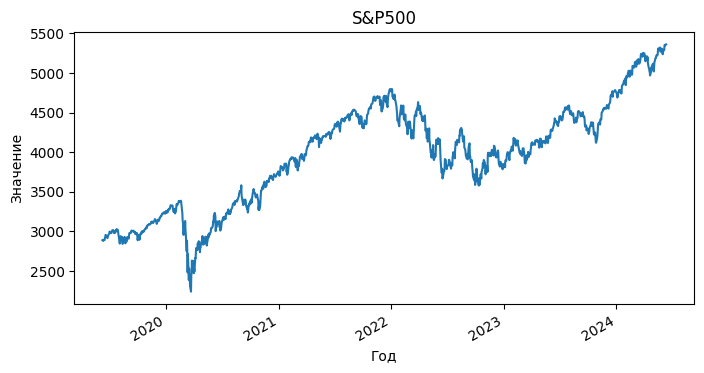

In [ ]:
ax = sp500.plot(figsize = (8,4), legend = None)
ax.set(title = 'S&P500', xlabel = 'Год', ylabel = 'Значение');

In [ ]:
train_data = sp500[:-365]
test_data = sp500[-365:]

In [ ]:
test_data.shape

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(sp500['Value'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.762633784296411


##CPI_M_CHI

In [ ]:
cpi = pd.read_csv('CPI_M_CHI.csv', delimiter=';')
cpi[['Month', 'CPI_M_CHI']] = cpi['Month;CPI_M_CHI'].str.split(';', expand=True)
cpi = cpi.drop(columns=['Month;CPI_M_CHI'])
cpi['Month'] = pd.to_datetime(cpi['Month'], format='%Y-%m')
cpi['CPI_M_CHI'] = cpi['CPI_M_CHI'].str.replace(',', '.').astype(float)
cpi.set_index('Month', inplace=True)
cpi.head()

,CPI_M_CHI
Month,
1992-01-01,345.0
1992-02-01,346.0
1992-03-01,347.0
1992-04-01,348.0
1992-05-01,349.0


In [ ]:
cpi = cpi['1993-01':]

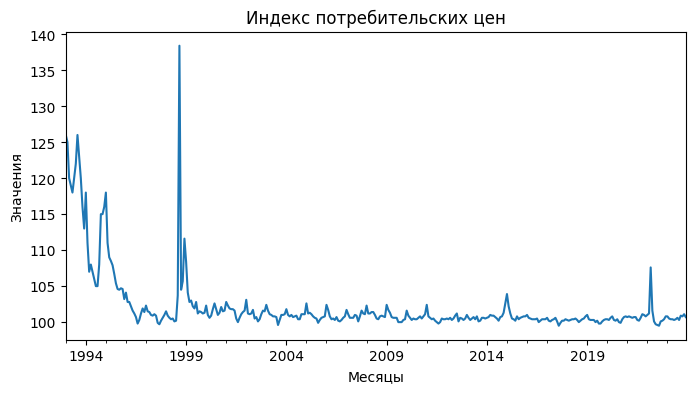

In [ ]:
ax = cpi.plot(figsize = (8,4), legend = None)
ax.set(title = 'Индекс потребительских цен', xlabel = 'Месяцы', ylabel = 'Значения');

In [ ]:
train_data = cpi[:'2022-12']
test_data = cpi['2023-01':]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data)
plt.plot(test_data)

plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Значения')
plt.xlabel('Месяцы')

plt.grid()

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(cpi['CPI_M_CHI'])
print('p-value = ' + str(adf_test[1]))

p-value = 7.4514614691040805e-06


##Passengers

In [ ]:
passengers = pd.read_csv("/content/passengers.csv", index_col = 'Month', parse_dates = True)
passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


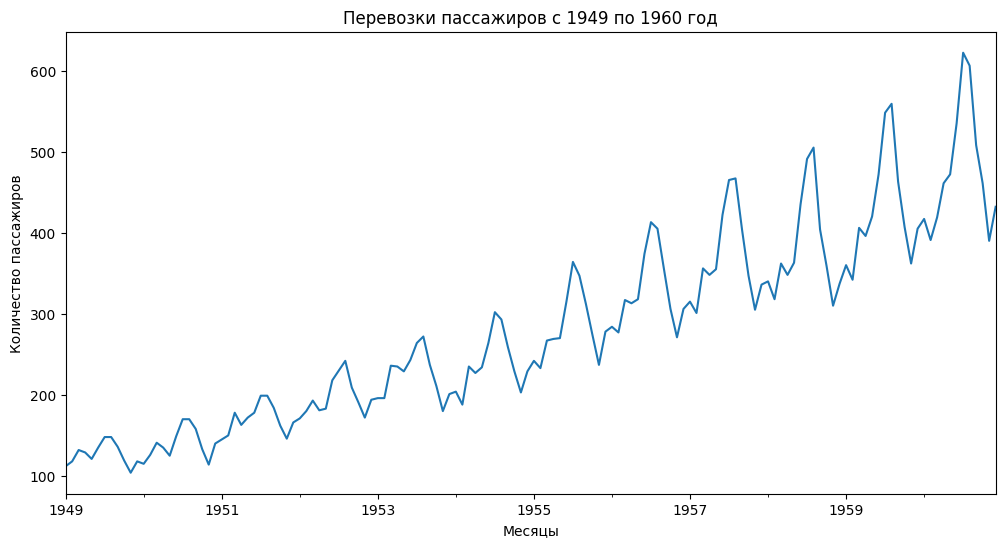

In [ ]:
ax = passengers.plot(figsize = (12,6), legend = None)
ax.set(title = 'Перевозки пассажиров с 1949 по 1960 год', xlabel = 'Месяцы', ylabel = 'Количество пассажиров');

In [ ]:
train_data = passengers[:'1959-12']
test_data = passengers['1960-01':]

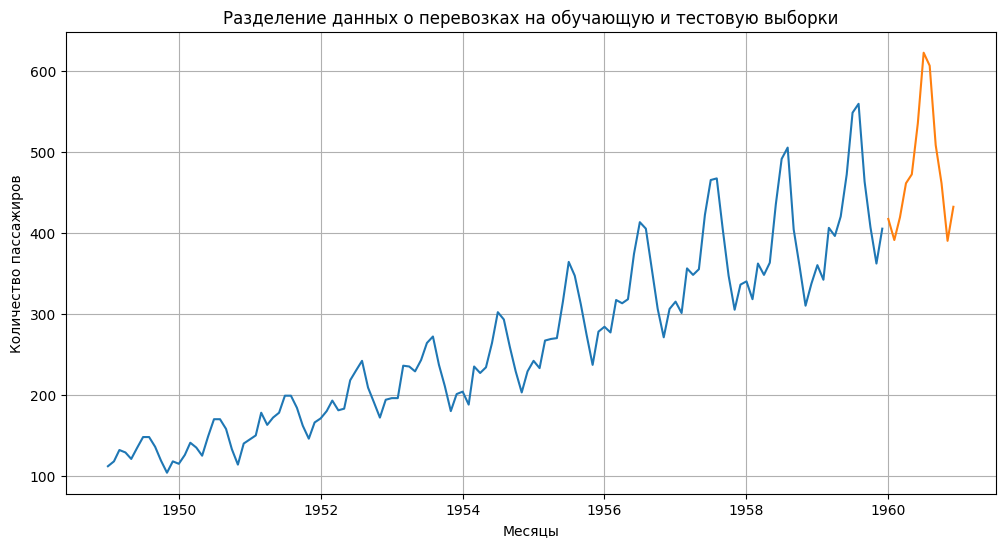

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_data)
plt.plot(test_data)

plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

plt.grid()

plt.show()

#LSTM-Prophet


##Обучение Prophet

In [ ]:
from prophet import Prophet

In [ ]:
train_data_pr = train_data.copy()
train_data_pr = train_data_pr.reset_index()

test_data_pr = test_data.copy()
test_data_pr = test_data_pr.reset_index()

In [ ]:
train_data_pr.columns = ['ds','y']
test_data_pr.columns = ['ds','y']

In [ ]:
train_data_pr.head()

,ds,y
0,1993-01-01,126.0
1,1993-02-01,125.0
2,1993-03-01,120.0
3,1993-04-01,119.0
4,1993-05-01,118.0


###Gridsearch

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [ ]:
param_grid = {
    'seasonality_mode':('multiplicative','additive'), #
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.001, 0.005, 0.01, 0.1],
    #'holidays_prior_scale':[0.001, 0.1, 0.2],
    'n_changepoints' : [3, 5, 7, 10]
}

grid = ParameterGrid(param_grid)

best_params = None
best_rmse = float('inf')

# Проход по всем комбинациям параметров и выбор лучшей модели
for params in grid:
    model = Prophet(**params)
    model.fit(train_data_pr)

    future = model.make_future_dataframe(periods=len(test_data), freq='M') #'D'
    forecast = model.predict(future)

    rmse = np.sqrt(mean_squared_error(forecast[-len(test_data):]["yhat"], test_data_pr['y']))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print('\n')
print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_rvb28is/_z0i6y5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_rvb28is/er4ge1ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53174', 'data', 'file=/tmp/tmp_rvb28is/_z0i6y5a.json', 'init=/tmp/tmp_rvb28is/er4ge1ic.json', 'output', 'file=/tmp/tmp_rvb28is/prophet_modelq73mpfm9/prophet_model-20240519113821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit



Best parameters: {'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}
Best RMSE: 0.20468038689818985


In [ ]:
m = Prophet(**best_params)
#m = Prophet() #changepoint_prior_scale = 0.05, seasonality_prior_scale = 10, holidays_prior_scale = 10, seasonality_mode = 'additive'
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=len(test_data),freq='M')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7__ntc0m/tulzg5b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7__ntc0m/dqy8i4_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99967', 'data', 'file=/tmp/tmp7__ntc0m/tulzg5b_.json', 'init=/tmp/tmp7__ntc0m/dqy8i4_n.json', 'output', 'file=/tmp/tmp7__ntc0m/prophet_modelznan2z_t/prophet_model-20240610192937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


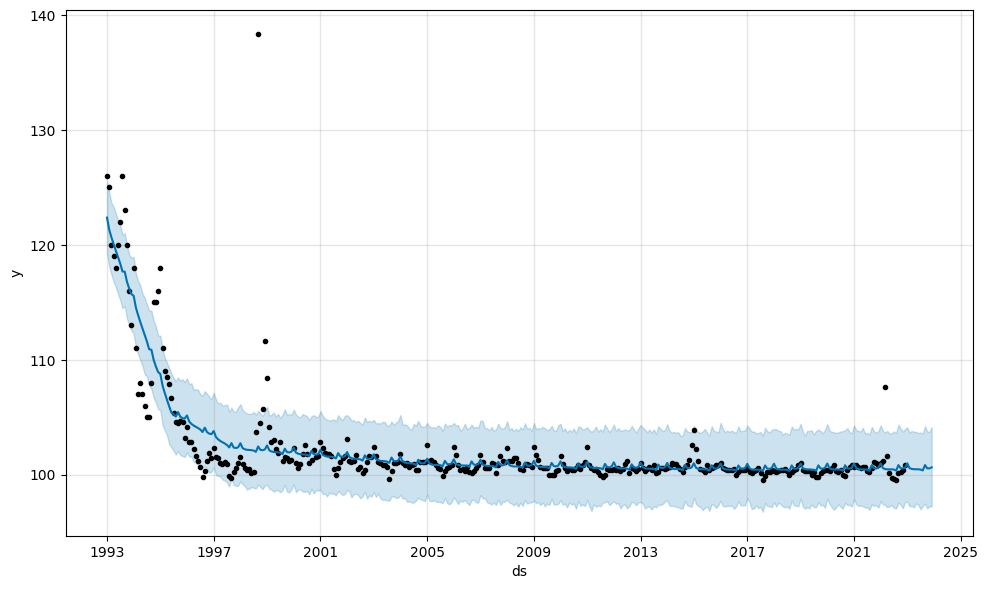

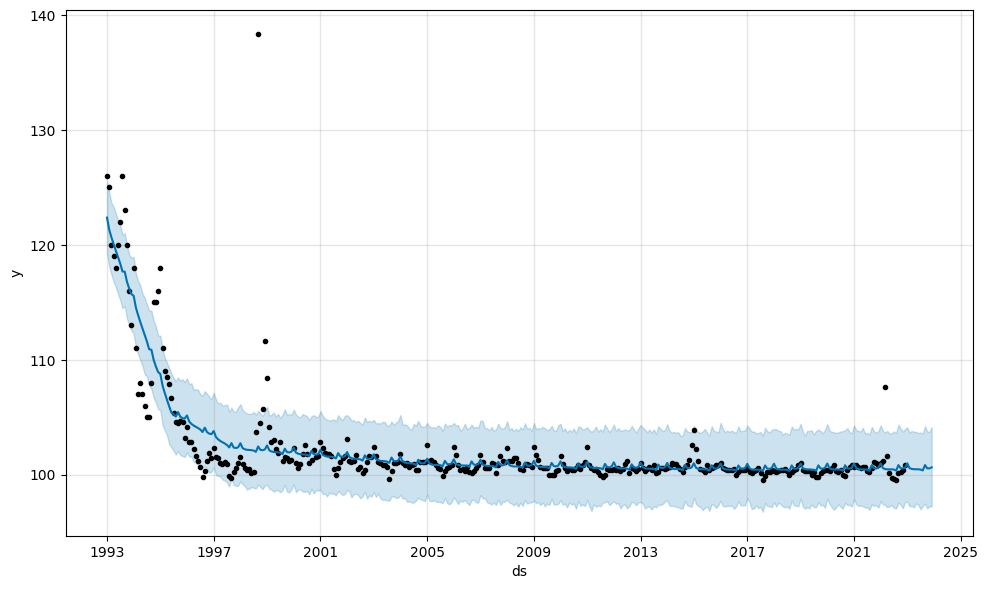

In [ ]:
m.plot(forecast)

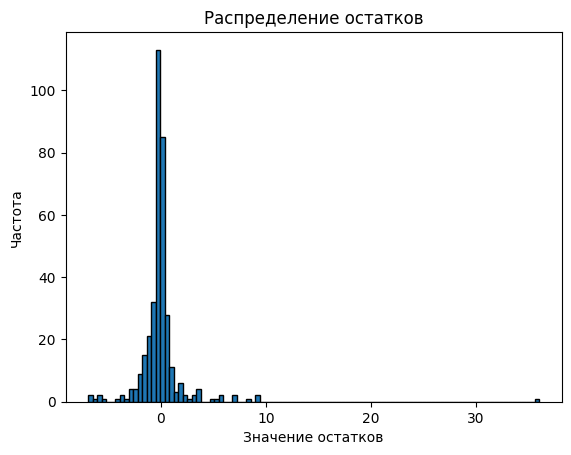

In [ ]:
residuals = prophet_result['residuals'][:-12].values

plt.hist(residuals, bins=100, edgecolor='black')  # Создаем гистограмму с 10 бинами и черной обводкой
plt.title('Распределение остатков')  # Устанавливаем заголовок гистограммы
plt.xlabel('Значение остатков')  # Устанавливаем подпись оси x
plt.ylabel('Частота')  # Устанавливаем подпись оси y
plt.show()  # Отображаем гистограмму

In [ ]:
print_metrics(forecast[-len(test_data):]["yhat"], test_data_pr['y'])

MAE: 0.15023180606761835
RMSE: 0.20468038689818985


CPI_M_CHI

Результаты на тестовый год

In [ ]:
prophet_result = pd.DataFrame(columns=['Month', 'raw', 'predicted', 'residuals'])
prophet_result['Month'] = forecast[-len(test_data):]['ds']
prophet_result['predicted'] = round(forecast[-len(test_data):]['yhat'],1)
prophet_result.set_index('Month', inplace=True)
prophet_result['raw'] = test_data['CPI_M_CHI'].values
prophet_result['residuals'] = prophet_result['raw'] - prophet_result['predicted']
prophet_result

,raw,predicted,residuals
Month,,,
2022-12-31,100.8,101.0,-0.2
2023-01-31,100.5,100.6,-0.1
2023-02-28,100.4,100.5,-0.1
2023-03-31,100.4,100.5,-0.1
2023-04-30,100.3,100.5,-0.2
2023-05-31,100.4,100.5,-0.1
2023-06-30,100.6,100.4,0.2
2023-07-31,100.3,100.4,-0.1
2023-08-31,100.9,100.8,0.1


residuals на всем датасете

In [ ]:
prophet_result = pd.DataFrame(columns=['Month', 'raw', 'predicted', 'residuals'])
prophet_result['Month'] = forecast[-len(train_data+test_data):]['ds']
prophet_result['predicted'] = round(forecast[-len(train_data+test_data):]['yhat'], 1)
prophet_result.set_index('Month', inplace=True)
prophet_result['raw'] = cpi['CPI_M_CHI'].values
prophet_result['residuals'] = prophet_result['raw'] - prophet_result['predicted']
prophet_result

,raw,predicted,residuals
Month,,,
1993-01-01,126.0,122.4,3.6
1993-02-01,125.0,121.3,3.7
1993-03-01,120.0,120.7,-0.7
1993-04-01,119.0,120.1,-1.1
1993-05-01,118.0,119.5,-1.5
...,...,...,...
2023-07-31,100.3,100.4,-0.1
2023-08-31,100.9,100.8,0.1
2023-09-30,100.8,100.5,0.3


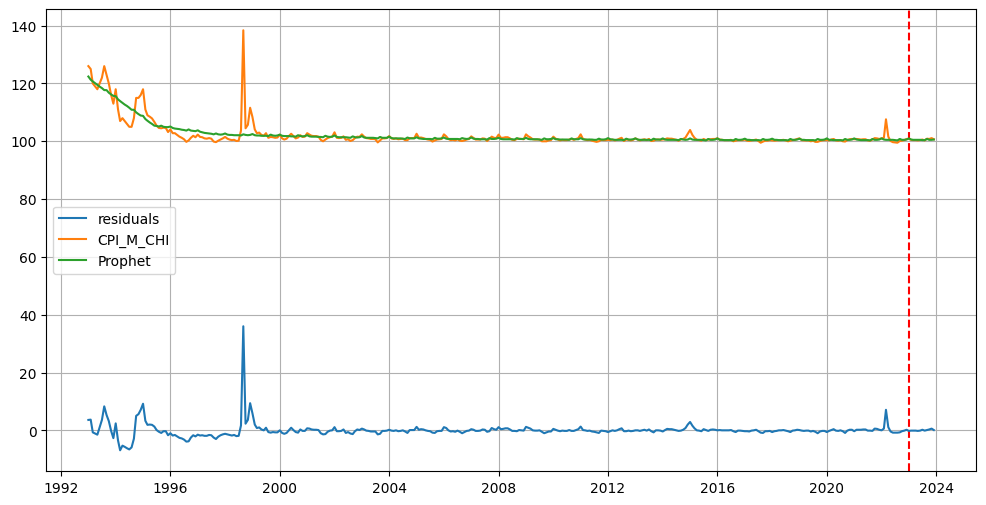

In [ ]:
plt.figure(figsize=(12,6))
plt.axvline(pd.to_datetime('2022-12-31'), c='r', linestyle='--')
plt.plot(prophet_result['residuals'], label = 'residuals')
plt.plot(prophet_result['raw'], label = 'CPI_M_CHI')
plt.plot(prophet_result['predicted'], label = 'Prophet') # [-365:]
plt.grid()
plt.legend()

SP500

Результаты на тестовый год

In [ ]:
prophet_result = pd.DataFrame(columns=['Day', 'raw', 'predicted', 'residuals'])
prophet_result['Day'] = forecast[-len(test_data):]['ds'] # test_data_pr['ds']
prophet_result['predicted'] = forecast[-len(test_data):]['yhat']
prophet_result.set_index('Day', inplace=True)
prophet_result['raw'] = test_data['Value']
prophet_result['residuals'] = prophet_result['raw'] - prophet_result['predicted']
prophet_result

,raw,predicted,residuals
Day,,,
2022-12-24,NaN,4518.076808,NaN
2022-12-25,NaN,4519.583175,NaN
2022-12-26,NaN,4520.992168,NaN
2022-12-27,3829.250000,4522.621151,-693.371151
2022-12-28,3783.219971,4524.152258,-740.932287
...,...,...,...
2023-12-19,4768.370117,4956.340236,-187.970118
2023-12-20,4698.350098,4957.816228,-259.466130
2023-12-21,4746.750000,4959.190577,-212.440577


residuals на всем датасете

In [ ]:
prophet_result = pd.DataFrame(columns=['Day', 'raw', 'predicted', 'residuals'])
prophet_result['Day'] = sp500.index #forecast[-len(train_data+test_data):]['ds']
prophet_result['predicted'] = forecast[-len(train_data+test_data):]['yhat']
prophet_result.set_index('Day', inplace=True)
prophet_result['raw'] = sp500['Value']
prophet_result['residuals'] = prophet_result['raw'] - prophet_result['predicted']
prophet_result

,raw,predicted,residuals
Day,,,
2019-06-10,2886.729980,2935.992762,-49.262782
2019-06-11,2885.719971,2937.225253,-51.505282
2019-06-12,2879.840088,2938.368301,-58.528213
2019-06-13,2891.639893,2939.390269,-47.750377
2019-06-14,2886.979980,2940.446066,-53.466086
...,...,...,...
2024-06-04,5291.339844,4956.340236,334.999608
2024-06-05,5354.029785,4957.816228,396.213557
2024-06-06,5352.959961,4959.190577,393.769384


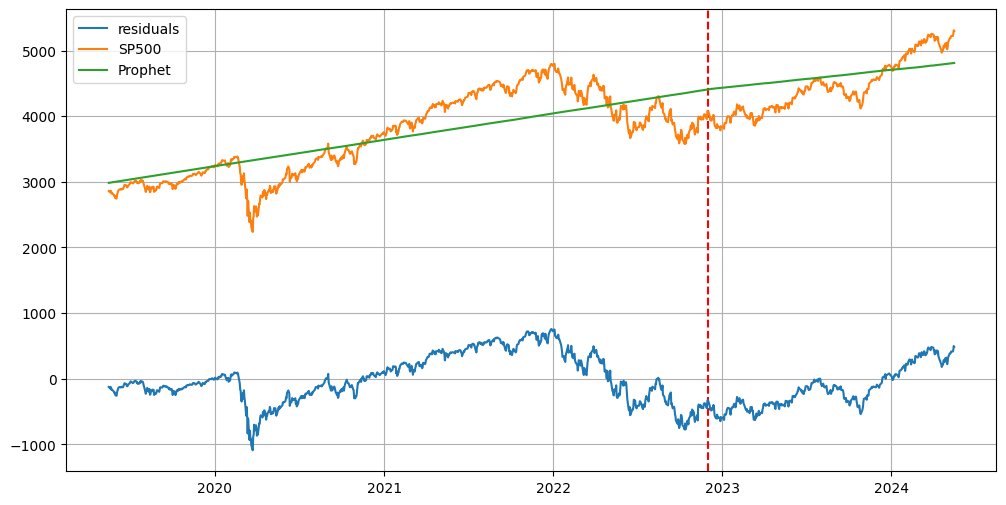

In [ ]:
plt.figure(figsize=(12,6))
plt.axvline(pd.to_datetime('2022-12-02'), c='r', linestyle='--')
plt.plot(prophet_result['residuals'], label = 'residuals')
plt.plot(prophet_result['raw'], label = 'SP500')
plt.plot(prophet_result['predicted'], label = 'Prophet') # [-365:]
plt.grid()
plt.legend()

##LSTM


###Предобработка данных

Методы обработки временных рядов:
1. Метод скользящего окна
2. Заполнение пропущенных значений
3. Удаление сезонности
4. Масштабирование (нормализация)

residuals

In [ ]:
res_data = prophet_result['residuals']
res_data = np.array(res_data).reshape(-1,1)
train_data = res_data[:-40] #420 for prophet sp500
test_data = res_data[-40:]

raw

In [ ]:
sp500 = np.array(sp500).reshape(-1, 1)
train_data = np.array(sp500[:-730])
test_data = np.array(sp500[-730:])

In [ ]:
cpi = np.array(cpi).reshape(-1, 1)
train_data = cpi[:-40]
test_data = cpi[-40:]

prepare

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(train_data) # np.array(train_data)
df_test = scaler.fit_transform(test_data) # np.array(test_data)

In [ ]:
# df_train = train_data
# df_test = test_data
seq_length = 24
x_train, y_train = sliding_windows(df_train, seq_length)
x_test, y_test = sliding_windows(df_test, seq_length)

In [ ]:
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, '\n')
print(y_batch.shape, '\n')

torch.Size([16, 24, 1]) 

torch.Size([16, 1]) 



In [ ]:
x_batch, y_batch = next(iter(test_loader))
print(x_batch.shape, '\n')
print(y_batch.shape, '\n')

torch.Size([15, 24, 1]) 

torch.Size([15, 1]) 



In [ ]:
y_test.shape

torch.Size([15, 1])

###LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

###Обучение LSTM

CPI_M_CHI

Epoch: 0, loss: 0.00103
Epoch: 50, loss: 0.00002


MAE: 0.04317058250308037
RMSE: 0.053717926144599915


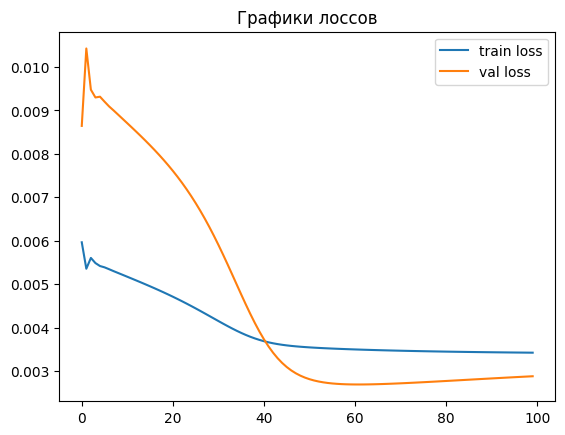

In [ ]:
num_epochs = 100
learning_rate = 1e-3

input_size = 1
hidden_size = 8
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
train(lstm, loss_fn, optimizer, num_epochs, train_loader, test_loader)
prediction = predict(lstm, test_loader) # прогнозируем на данных с имеющейся сезонностью
print('\n')
print_metrics(y_test, prediction)

raw

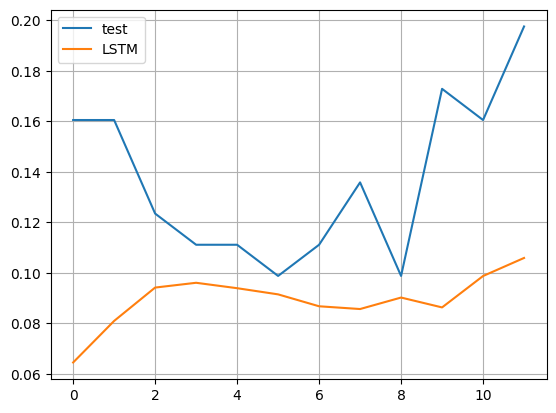

In [ ]:
plt.plot(y_test[-12:], label = 'test')
plt.plot(prediction[-12:], label = 'LSTM')
plt.grid()
plt.legend()

In [ ]:
prediction_raw = scaler.inverse_transform(prediction)
prediction_raw = prediction_raw.reshape(-1)
print_metrics(test_data[-12:], prediction_res[-12:])

MAE: 100.66375109404326
RMSE: 100.66399636292564


res

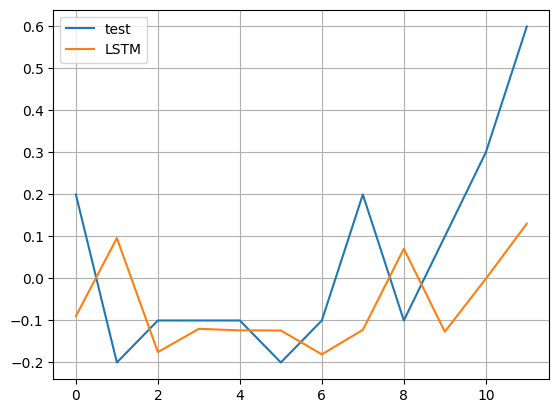

In [ ]:
plt.plot(y_test[-12:], label = 'test')
plt.plot(prediction[-12:], label = 'LSTM')
plt.grid()
plt.legend()

In [ ]:
prediction_res = prediction
prediction_res = prediction_res.reshape(-1)
print_metrics(test_data[-12:], prediction_res[-12:])

MAE: 0.16599905714392568
RMSE: 0.25053280457750077


с нормировкой

In [ ]:
prediction_res = scaler.inverse_transform(prediction)
prediction_res = prediction_res.reshape(-1)
print_metrics(test_data[-12:], prediction_res[-12:])

MAE: 0.2628890792528769
RMSE: 0.29046492754352227


SP500

Epoch: 0, loss: 0.13795
Epoch: 50, loss: 0.01760


MAE: 0.18419963121414185
RMSE: 0.22154109179973602


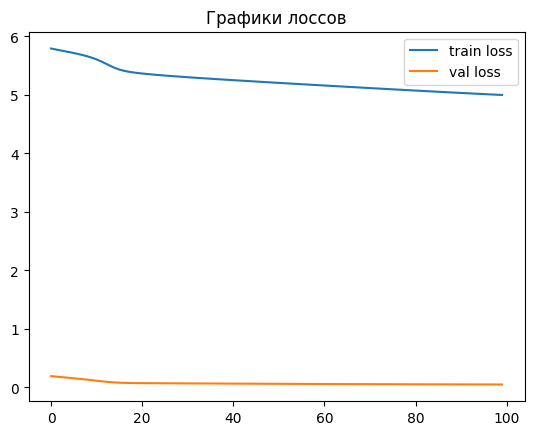

In [ ]:
num_epochs = 100
learning_rate = 1e-3

input_size = 1
hidden_size = 8
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
train(lstm, loss_fn, optimizer, num_epochs, train_loader, test_loader)
prediction = predict(lstm, test_loader) # прогнозируем на данных с имеющейся сезонностью
print('\n')
print_metrics(y_test, prediction)

raw

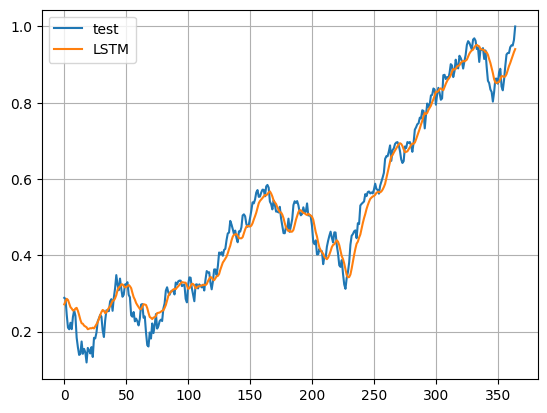

In [ ]:
plt.plot(y_test[-365:], label = 'test')
plt.plot(prediction[-365:], label = 'LSTM')
plt.grid()
plt.legend()

In [ ]:
prediction_raw = scaler.inverse_transform(prediction)
prediction_raw = prediction_raw.reshape(-1)
print_metrics(test_data[-365:], prediction_raw[-365:])

MAE: 54.55697907748288
RMSE: 68.59711235460047


residuals

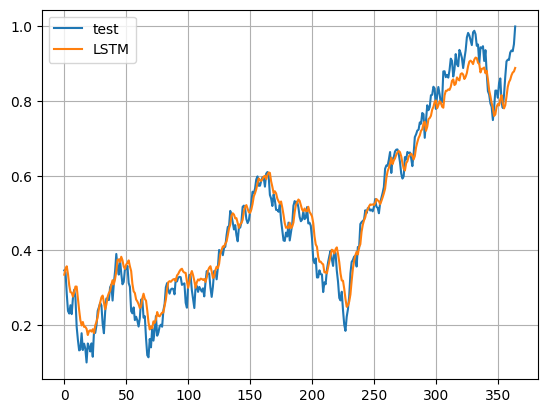

In [ ]:
plt.plot(y_test[-365:], label = 'test')
plt.plot(prediction[-365:], label = 'LSTM')
plt.grid()
plt.legend()

In [ ]:
prediction_res = scaler.inverse_transform(prediction)
prediction_res = prediction_res.reshape(-1)
print_metrics(test_data[-365:], prediction_res[-365:])

MAE: 52.021354220894544
RMSE: 65.02901822536278


#Прогнозирование

In [ ]:
result = prophet_result.tail(12) # 365

In [ ]:
result['LSTM_res'] = np.round(prediction_res[-12:], 1) #-365
result['LSTM_raw'] = np.round(prediction_raw[-12:], 1)
result['Hybrid'] = result['predicted'] + result['LSTM_res']
result

,raw,predicted,residuals,LSTM_res,LSTM_raw,Hybrid
Month,,,,,,
2022-12-31,100.8,101.0,-0.2,-0.1,100.000000,100.9
2023-01-31,100.5,100.6,-0.1,0.1,100.099998,100.7
2023-02-28,100.4,100.5,-0.1,-0.2,100.199997,100.3
2023-03-31,100.4,100.5,-0.1,-0.1,100.300003,100.4
2023-04-30,100.3,100.5,-0.2,-0.1,100.300003,100.4
2023-05-31,100.4,100.5,-0.1,-0.1,100.199997,100.4
2023-06-30,100.6,100.4,0.2,-0.2,100.199997,100.2
2023-07-31,100.3,100.4,-0.1,-0.1,100.199997,100.3
2023-08-31,100.9,100.8,0.1,0.1,100.199997,100.9


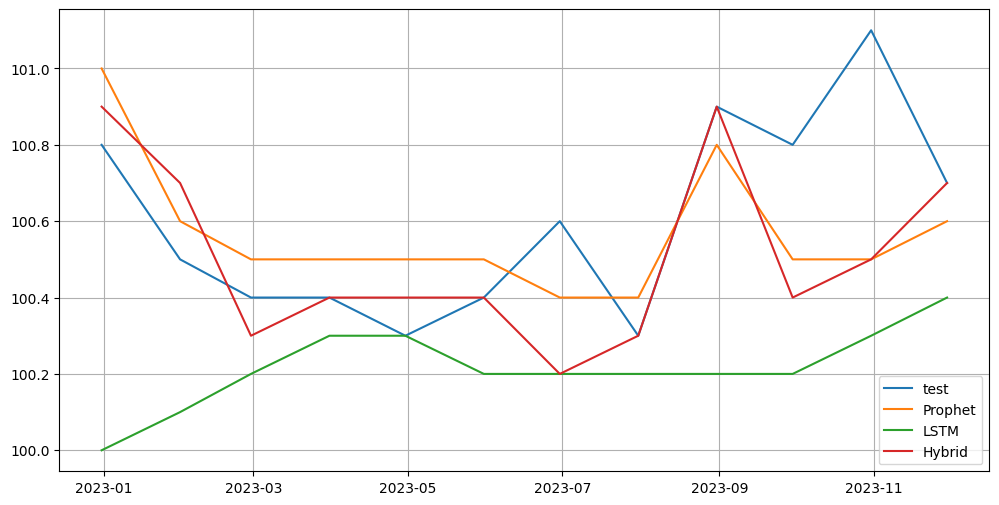

In [ ]:
plt.figure(figsize=(12,6))
# plt.axvline(pd.to_datetime('2022-12-02'), c='r', linestyle='--')
plt.plot(result['raw'][-12:], label = 'test')
plt.plot(result['predicted'][-12:], label = 'Prophet')
plt.plot(result['LSTM_raw'][-12:], label = 'LSTM')
plt.plot(result['Hybrid'][-12:], label = 'Hybrid')
plt.grid()
plt.legend()

In [ ]:
print('Hybrid RMSE: ', np.sqrt(mean_squared_error(result['raw'], result['Hybrid'])))
print('Hybrid MAE: ',  mean_absolute_error(result['raw'], result['Hybrid']))
print('Hybrid MAPE: ',  mean_absolute_percentage_error(result['raw'], result['Hybrid']))
print('----------------------------------')
print('Prophet RMSE: ', np.sqrt(mean_squared_error(result['raw'], result['predicted'])))
print('Prophet MAE: ', mean_absolute_error(result['raw'], result['predicted']))
print('Prophet MAPE: ',  mean_absolute_percentage_error(result['raw'], result['predicted']))
print('----------------------------------')
print('LSTM RMSE: ', np.sqrt(mean_squared_error(result['raw'], result['LSTM_raw'])))
print('LSTM MAE: ', mean_absolute_error(result['raw'], result['LSTM_raw']))
print('LSTM MAPE: ', mean_absolute_percentage_error(result['raw'], result['LSTM_raw']))

Hybrid RMSE:  0.25000000069538447
Hybrid MAE:  0.15833333445091805
Hybrid MAPE:  0.0015711877913603825
----------------------------------
Prophet RMSE:  0.23094010767584844
Prophet MAE:  0.18333333333333238
Prophet MAPE:  0.0018201113060249989
----------------------------------
LSTM RMSE:  0.46904230795620155
LSTM MAE:  0.38333460489908927
LSTM MAPE:  0.0038043364604107392


#M3 Competition

##M3_year

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [ ]:
from prophet import Prophet

In [ ]:
def prophet_forecast(train_df, test_df):
    param_grid = {
    'seasonality_mode':('multiplicative','additive'), #
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 1],
    'holidays_prior_scale':[0.01, 0.1, 0.5],
    'n_changepoints' : [3, 5, 7, 10]
    }

    grid = ParameterGrid(param_grid)

    best_params = None
    best_forecast = None
    best_rmse = float('inf')

    for params in grid:
        model = Prophet(**params)
        model.fit(train_df)

        future = model.make_future_dataframe(periods=len(test_df), freq='Y') #'D'
        forecast = model.predict(future)

        rmse = np.sqrt(mean_squared_error(forecast[-len(test_df):]["yhat"], test_df['y']))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_forecast = forecast

    return best_forecast

In [ ]:
def prepare_data(time_series, train_size, test_size, scaler):
    ts = np.array(time_series).reshape(-1, 1)
    seq_length = test_size
    train_data = ts[:(train_size-2)]
    test_data = ts[-(test_size+2):]

    df_train = scaler.fit_transform(np.array(train_data))
    df_test = scaler.fit_transform(np.array(test_data))

    seq_length = 1
    x_train, y_train = sliding_windows(df_train, seq_length)
    x_test, y_test = sliding_windows(df_test, seq_length)

    x_train = torch.Tensor(x_train)
    x_test = torch.Tensor(x_test)
    y_train = torch.Tensor(y_train)
    y_test = torch.Tensor(y_test)

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def lstm_forecast(train_loader, test_loader, mode):
    num_epochs = 100
    learning_rate = 1e-3

    input_size = 1
    hidden_size = 2
    num_layers = 1

    num_classes = 1

    model = LSTM(num_classes, input_size, hidden_size, num_layers)

    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = 0
        avg_val_loss = 0

        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() / len(train_loader)
        train_losses.append(avg_train_loss)

        # if epoch % 50 == 0:
        #     print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                avg_val_loss += loss.item() / len(test_loader)
            val_losses.append(avg_val_loss)
    if mode == 'raw':
        prediction = predict(model, test_loader)
        prediction = scaler_raw.inverse_transform(prediction)
        prediction = prediction.reshape(-1)
    else:
        prediction = predict(model, test_loader)
        prediction = scaler_res.inverse_transform(prediction)
        prediction = prediction.reshape(-1)
    return prediction

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [ ]:
m3 =  pd.read_excel("M3C.xls", sheet_name=0)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
results = pd.DataFrame(columns=['Series Name', 'RMSE_Prophet', 'MAE_Prophet','MAPE_Prophet', 'RMSE_LSTM', 'MAE_LSTM', 'MAPE_LSTM', 'RMSE_HYBRID', 'MAE_HYBRID', 'MAPE_HYBRID'])
for i in range(501, 600): # m3.shape[0]
    try:
        print(f'TIMESERIES №{i}:')

        # предобработка временного ряда
        ts = m3.iloc[i, 6:6+m3.iloc[i]['N']]
        ts = ts.astype(float)
        start_year = m3.iloc[i]['Starting Year']
        date_rng = pd.date_range(start=f'{start_year}-01-01', periods=m3.iloc[i]['N'], freq='Y')
        ts.index = date_rng

        # разбиение
        train = ts.head(ts.size - m3.iloc[i]['NF']).copy()
        test = ts.tail(m3.iloc[i]['NF']).copy()
        train_size = train.shape[0]
        test_size = test.shape[0]

        #разбиение для Prophet
        train_df = pd.DataFrame({'ds': train.index, 'y': train.values})
        test_df = pd.DataFrame({'ds': test.index, 'y': test.values})

        #Обучение Prophet
        forecast_prophet = prophet_forecast(train_df, test_df)
        forecast_prophet.index = ts.index
        prophet_pred = forecast_prophet[-len(test_df):]["yhat"]

        #Преобработка данных
        residuals = ts - forecast_prophet["yhat"]
        scaler_raw = MinMaxScaler(feature_range=(0,1))
        scaler_res = MinMaxScaler(feature_range=(0,1))
        train_loader_raw, test_loader_raw = prepare_data(ts, train_size, test_size, scaler_raw)
        train_loader_res, test_loader_res = prepare_data(residuals, train_size, test_size, scaler_res)

        #Обучение LSTM на исходных и на остатках
        lstm_raw_pred = lstm_forecast(train_loader_raw, test_loader_raw, 'raw')
        lstm_res_pred = lstm_forecast(train_loader_res, test_loader_res, 'res')
        hybrid = lstm_res_pred + prophet_pred

        rmse_prophet = np.sqrt(mean_squared_error(prophet_pred.values, test.values))
        mae_prophet = mean_absolute_error(prophet_pred.values, test.values)
        mape_prophet = mean_absolute_percentage_error(prophet_pred.values, test.values)

        rmse_lstm = np.sqrt(mean_squared_error(lstm_raw_pred, test.values))
        mae_lstm = mean_absolute_error(lstm_raw_pred, test.values)
        mape_lstm = mean_absolute_percentage_error(lstm_raw_pred, test.values)

        rmse_hybrid =  np.sqrt(mean_squared_error(hybrid, test.values))
        mae_hybrid = mean_absolute_error(hybrid, test.values)
        mape_hybrid = mean_absolute_percentage_error(hybrid, test.values)

        results = pd.concat([
            results,
            pd.DataFrame({
                'Series Name': [m3.iloc[i]['Series']],
                'RMSE_Prophet': [rmse_prophet],
                'MAE_Prophet': [mae_prophet],
                'MAPE_Prophet': [mape_prophet],
                'RMSE_LSTM': [rmse_lstm],
                'MAE_LSTM': [mae_lstm],
                'MAPE_LSTM': [mape_lstm],
                'RMSE_HYBRID': [rmse_hybrid],
                'MAE_HYBRID': [mae_hybrid],
                'MAPE_HYBRID': [mape_hybrid]
            })
        ], ignore_index=True)
        #print("-------------------------------------------------------")
        print('DONE')
    except Exception:
        print('Что то пошло не так')
results.to_excel('M3_forecast_year.xlsx', index=False)

TIMESERIES №501:
DONE
TIMESERIES №502:
DONE
TIMESERIES №503:
DONE
TIMESERIES №504:
DONE
TIMESERIES №505:
DONE
TIMESERIES №506:
DONE
TIMESERIES №507:
DONE
TIMESERIES №508:
DONE
TIMESERIES №509:
DONE
TIMESERIES №510:
DONE
TIMESERIES №511:
DONE
TIMESERIES №512:
DONE
TIMESERIES №513:
DONE
TIMESERIES №514:
DONE
TIMESERIES №515:
DONE
TIMESERIES №516:
DONE
TIMESERIES №517:
DONE
TIMESERIES №518:
DONE
TIMESERIES №519:
DONE
TIMESERIES №520:
DONE
TIMESERIES №521:
DONE
TIMESERIES №522:
DONE
TIMESERIES №523:
DONE
TIMESERIES №524:
DONE
TIMESERIES №525:
DONE
TIMESERIES №526:
DONE
TIMESERIES №527:
DONE
TIMESERIES №528:
DONE
TIMESERIES №529:
DONE
TIMESERIES №530:
DONE
TIMESERIES №531:
DONE
TIMESERIES №532:
DONE
TIMESERIES №533:
DONE
TIMESERIES №534:
DONE
TIMESERIES №535:
DONE
TIMESERIES №536:
DONE
TIMESERIES №537:
DONE
TIMESERIES №538:
DONE
TIMESERIES №539:
DONE
TIMESERIES №540:
DONE
TIMESERIES №541:
DONE
TIMESERIES №542:
DONE
TIMESERIES №543:
DONE
TIMESERIES №544:
DONE
TIMESERIES №545:
DONE
TIMESERIES

In [ ]:
lstm_raw_pred_ = pd.Series(lstm_raw_pred)
lstm_raw_pred_.index = test.index

hybrid_ = pd.Series(hybrid)
hybrid_.index = test.index


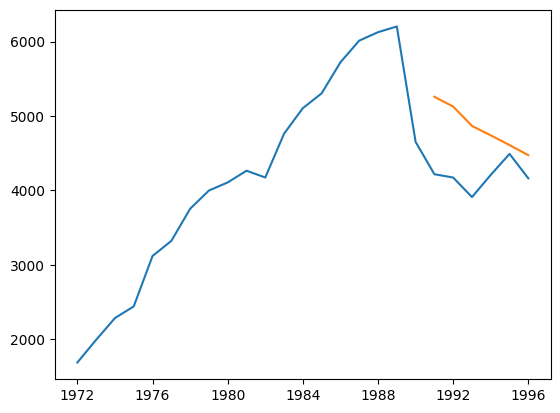

In [ ]:
plt.plot(ts)
plt.plot(prophet_pred)

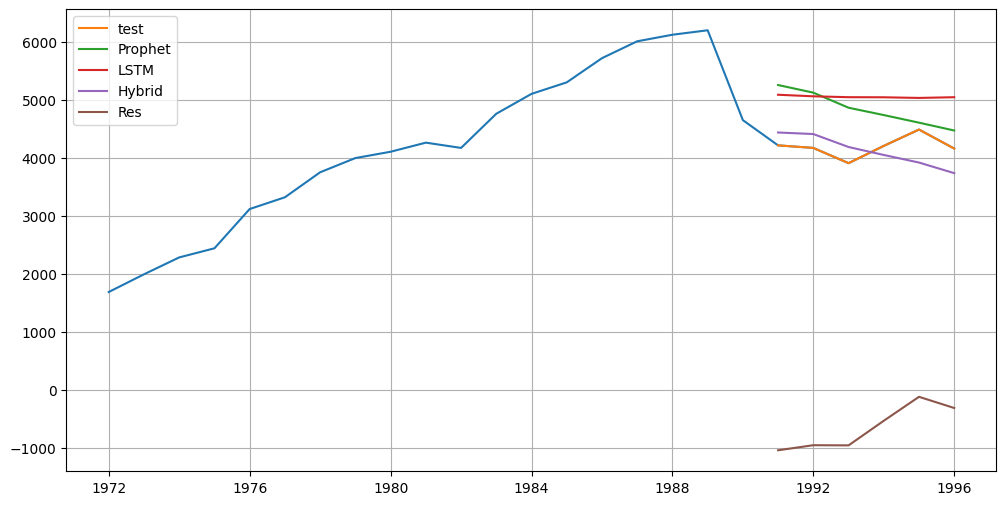

In [ ]:
plt.figure(figsize=(12,6))
# plt.axvline(pd.to_datetime('2022-12-02'), c='r', linestyle='--')
plt.plot(ts)
plt.plot(test, label = 'test')
plt.plot(prophet_pred, label = 'Prophet')
plt.plot(lstm_raw_pred_, label = 'LSTM')
plt.plot(hybrid, label = 'Hybrid')
plt.plot(residuals[-6:], label='Res')
plt.grid()
plt.legend()

In [ ]:
residuals[-6:]

1989-12-31    1892.308675
1990-12-31     708.912956
1991-12-31   -2104.218970
1992-12-31   -1439.029900
1993-12-31   -1042.930246
1994-12-31     318.674035
Freq: A-DEC, dtype: float64

In [ ]:
print(rmse_lstm, mae_lstm, mape_lstm)
print(rmse_prophet, mae_prophet, mape_prophet)
print(rmse_hybrid, mae_hybrid, mape_hybrid)

878.8088652143791 861.7100423177084 0.1704011303120683
741.5598310782665 651.9466577544287 0.13128826670536123
344.5733644962512 314.938419039953 0.07797948083217998
